In [ ]:

from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/SML/fake_or_real_news.csv'

df = pd.read_csv(file_path)

print(df.head())

Mounted at /content/drive
   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


In [ ]:
import pandas as pd
import numpy as np
import itertools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
import seaborn as sns
import re
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier



Preprocessing- Getting rid of rows with missing values.

In [ ]:

df.dropna(inplace=True)

print(f"DataFrame shape after dropping missing values: {df.shape}")


DataFrame shape after dropping missing values: (6335, 4)


Preprocessing- Converting text to lowercase

In [ ]:
df['text'] = df['text'].str.lower()
df['title']=df['title'].str.lower()


Preprocessing- Getting rid of punctuations

In [ ]:
import string


df['title'] = df['title'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


Preprocessing- Getting rid of numbers

In [ ]:
df['title'] = df['title'].str.replace(r'\d+', '', regex=True)
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)

Preprocessing- Getting rid of characters that is not in the ASCII range (which includes all English letters and common punctuation).

In [ ]:
df['title'] = df['title'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
df['text'] = df['text'].str.replace(r'[^\x00-\x7F]+', '', regex=True)

EDA- Checking for missing values

In [ ]:

print(df.isnull().sum())


Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


Saving changes made into a new csv file

In [ ]:

df.to_csv('fake_vs_real_news2.csv', index=False)


EDA- Number of fake and real entries in the dataset

In [ ]:
i=df.label.value_counts()
print(i)

label
REAL    3171
FAKE    3164
Name: count, dtype: int64


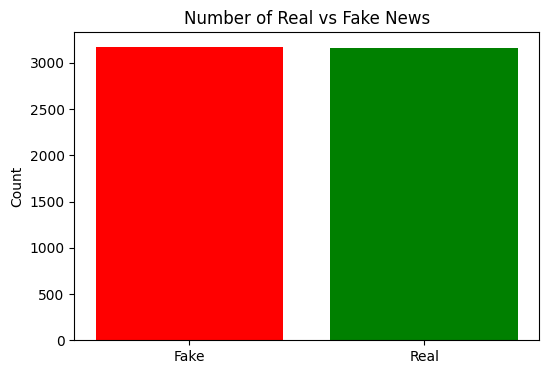

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(['Fake', 'Real'], i, color=['red', 'green'])
plt.title('Number of Real vs Fake News')
plt.ylabel('Count')
plt.show()

Splitting data into training and testing sets

In [ ]:
df['combined'] = df['title'] + " " + df['text']
X=df['combined']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Vectorization of data

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')

In [ ]:
tfidf_train=tfidf.fit_transform(X_train)
tfidf_test=tfidf.transform(X_test)

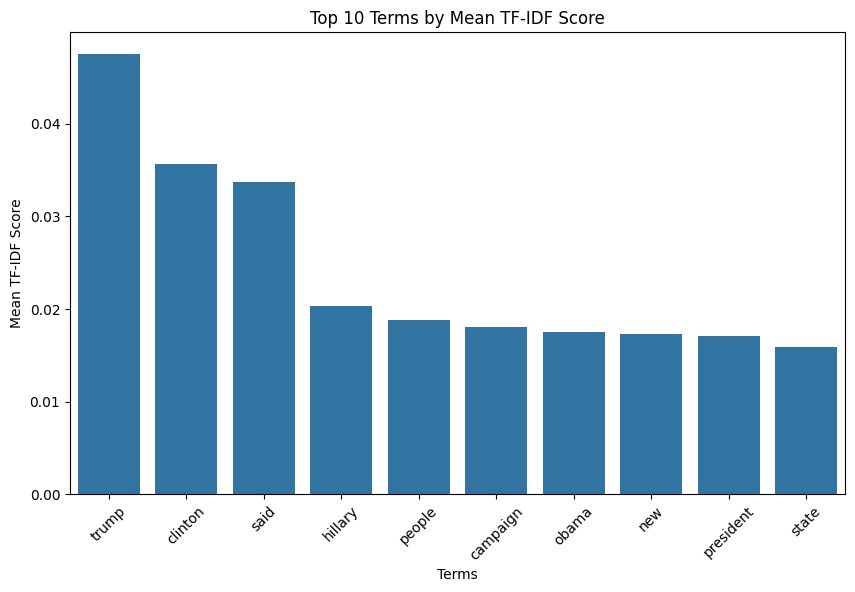

In [ ]:
tfidf_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf.get_feature_names_out())

# Calculate the mean TF-IDF score for each term across the training documents
mean_tfidf = tfidf_df.mean(axis=0).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_tfidf.index[:10], y=mean_tfidf.values[:10])  # Plot top 10 terms
plt.xticks(rotation=45)
plt.title("Top 10 Terms by Mean TF-IDF Score")
plt.xlabel("Terms")
plt.ylabel("Mean TF-IDF Score")
plt.show()

In [ ]:
pca = PCA(n_components=100)  # Choose the number of principal components to keep

# Apply PCA to the training and testing data
X_train_pca = pca.fit_transform(tfidf_train.toarray())  # Convert sparse matrix to dense before applying PCA
X_test_pca = pca.transform(tfidf_test.toarray())

Model Application

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier


# Define each individual model
bernoulli_nb = BernoulliNB()
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
log_reg = LogisticRegression(max_iter=1000)

# Combine them into a voting classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('bernoulli_nb', bernoulli_nb),
        ('random_forest', random_forest),
        ('decision_tree', decision_tree),
        ('log_reg', log_reg)
    ],
    voting='soft'  # Use 'soft' voting for averaging probabilities
)

# Train the ensemble model
ensemble_model.fit(X_train_pca, y_train)


VotingClassifier(estimators=[('bernoulli_nb', BernoulliNB()),
                             ('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('decision_tree',
                              DecisionTreeClassifier(random_state=42)),
                             ('log_reg', LogisticRegression(max_iter=1000))],
                 voting='soft')

In [ ]:
 from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = ensemble_model.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Model Accuracy:", accuracy)

# Display detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Show confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Ensemble Model Accuracy: 0.8831886345698501
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.88      0.89      0.88       628
        REAL       0.89      0.88      0.88       639

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267

Confusion Matrix:
 [[556  72]
 [ 76 563]]


In [ ]:
import joblib

# Save the trained model
joblib.dump(ensemble_model, 'ensemble_model.pkl')
# Save the TF-IDF Vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [ ]:
from google.colab import files

files.download('ensemble_model.pkl')
files.download('tfidf_vectorizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>